In [1]:
import torch, tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

def Accuracy(TRUTH, PREDICTION, BATCH_SIZE):
    return (TRUTH==PREDICTION).sum().item()/BATCH_SIZE

# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

GPU State: cuda:0


In [2]:
# Data
valid_size=0.2
shuffle = True
random_seed = 100
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
valSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

num_train = len(trainSet)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=64, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

In [3]:
class Shallow_Net(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.25),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=20*144, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)
net_1 = Shallow_Net().to(device)

In [4]:
def train_fn(epochs, lr, optimizer_name, net, name_of_net):
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
    else : 
        print("Error, please input 'SGD' or Adam.")
    # Train
    epoch_loss = []
    epoch_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_loss_val = 0.0
        running_acc_val = 0.0
        
        for times, data in enumerate(trainLoader):
            net.train()
#             print("Training")
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Foward + backward + optimize
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            running_acc += Accuracy(labels, predicted, trainLoader.batch_size)
#             if times % 100 == 99 or times+1 == len(trainLoader):
#                 print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(trainLoader), running_loss/2000))
        with torch.no_grad():
            net.eval()
#             print("Validating.")
            for times_val, data_val in enumerate(valLoader):
                inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
        #         inputs = inputs.view(inputs.shape[0], -1)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Foward + backward + optimize
                outputs_val = net(inputs_val)
                _, predicted_val = torch.max(outputs_val.data, 1)
                loss_val = criterion(outputs_val, labels_val)
#                     loss_val.backward()
#                     optimizer.step()

                # Print statistics
                running_loss_val += loss_val.item()
                running_acc_val += Accuracy(labels_val, predicted_val, valLoader.batch_size)
            _epoch_val_loss = running_loss_val/len(valLoader)
            _epoch_val_acc = running_acc_val/len(valLoader)
            epoch_val_loss.append(_epoch_val_loss)
            epoch_val_acc.append(_epoch_val_acc)
                
        _epoch_loss = running_loss/len(trainLoader)
        _epoch_acc = running_acc/len(trainLoader)
        epoch_loss.append(_epoch_loss)
        epoch_acc.append(_epoch_acc)
        print("Epoch: {0}, loss: {1:.3f}, acc: {2:.3f}, val_loss: {3:.3f}, val_acc: {4:.3f}".format(epoch+1, _epoch_loss, _epoch_acc, _epoch_val_loss, _epoch_val_acc))
    print('Training Finished.')
    
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testLoader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]

    with torch.no_grad():
        net.eval()
        for data in testLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    #             print(class_correct)
    #             print(class_total)

    for i in range(10):
        print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))
    acc = (100*correct / total)
    x = np.linspace(1, epochs, num = epochs)
    plt.plot(x, epoch_acc, label='acc')
    plt.plot(x, epoch_loss, label='loss')
    plt.plot(x, epoch_val_loss, label='val_loss')
    plt.plot(x, epoch_val_acc, label='val_acc')
    plt.xlabel('epochs')
    plt.ylabel('acc/loss')
    plt.legend(loc="upper right")
    plt.savefig("mnist_cnn_"+optimizer_name+str(name_of_net)+"_ce_shallow_"+str(int(acc))+".png")
    plt.show()

Epoch: 1, loss: 1.557, acc: 0.910, val_loss: 1.503, val_acc: 0.958
Epoch: 2, loss: 1.498, acc: 0.964, val_loss: 1.487, val_acc: 0.972
Epoch: 3, loss: 1.490, acc: 0.972, val_loss: 1.489, val_acc: 0.970
Epoch: 4, loss: 1.487, acc: 0.975, val_loss: 1.483, val_acc: 0.976
Epoch: 5, loss: 1.484, acc: 0.978, val_loss: 1.484, val_acc: 0.974
Epoch: 6, loss: 1.483, acc: 0.978, val_loss: 1.489, val_acc: 0.969
Epoch: 7, loss: 1.481, acc: 0.981, val_loss: 1.481, val_acc: 0.978
Epoch: 8, loss: 1.480, acc: 0.981, val_loss: 1.482, val_acc: 0.976
Epoch: 9, loss: 1.481, acc: 0.980, val_loss: 1.479, val_acc: 0.980
Epoch: 10, loss: 1.480, acc: 0.981, val_loss: 1.480, val_acc: 0.979
Epoch: 11, loss: 1.478, acc: 0.983, val_loss: 1.481, val_acc: 0.977
Epoch: 12, loss: 1.479, acc: 0.982, val_loss: 1.479, val_acc: 0.979
Epoch: 13, loss: 1.477, acc: 0.984, val_loss: 1.479, val_acc: 0.980
Epoch: 14, loss: 1.477, acc: 0.984, val_loss: 1.478, val_acc: 0.980
Epoch: 15, loss: 1.477, acc: 0.985, val_loss: 1.479, val_

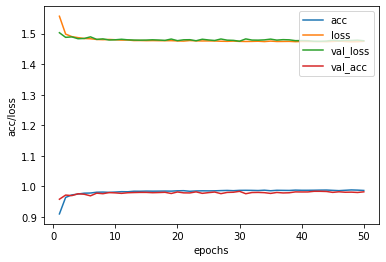

In [5]:
train_fn(50, 0.01, "Adam", net_1, "_compare")

Epoch: 1, loss: 1.736, acc: 0.746, val_loss: 1.615, val_acc: 0.846
Epoch: 2, loss: 1.607, acc: 0.857, val_loss: 1.591, val_acc: 0.870
Epoch: 3, loss: 1.588, acc: 0.874, val_loss: 1.580, val_acc: 0.881
Epoch: 4, loss: 1.580, acc: 0.883, val_loss: 1.578, val_acc: 0.882
Epoch: 5, loss: 1.576, acc: 0.886, val_loss: 1.574, val_acc: 0.887
Epoch: 6, loss: 1.573, acc: 0.888, val_loss: 1.572, val_acc: 0.887
Epoch: 7, loss: 1.572, acc: 0.890, val_loss: 1.572, val_acc: 0.887
Epoch: 8, loss: 1.512, acc: 0.950, val_loss: 1.487, val_acc: 0.973
Epoch: 9, loss: 1.486, acc: 0.977, val_loss: 1.485, val_acc: 0.975
Epoch: 10, loss: 1.484, acc: 0.979, val_loss: 1.484, val_acc: 0.976
Epoch: 11, loss: 1.483, acc: 0.980, val_loss: 1.482, val_acc: 0.977
Epoch: 12, loss: 1.482, acc: 0.981, val_loss: 1.481, val_acc: 0.979
Epoch: 13, loss: 1.480, acc: 0.982, val_loss: 1.481, val_acc: 0.978
Epoch: 14, loss: 1.479, acc: 0.983, val_loss: 1.480, val_acc: 0.979
Epoch: 15, loss: 1.479, acc: 0.983, val_loss: 1.481, val_

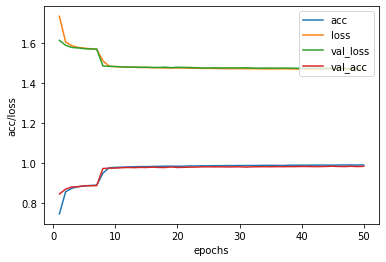

In [5]:
train_fn(50, 0.01, "SGD", net_1, "_compare")